In [1]:
from torchvision import models
fcn = models.segmentation.fcn_resnet50(pretrained=False, num_classes=3).eval()
fcn = fcn.to('cuda')

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



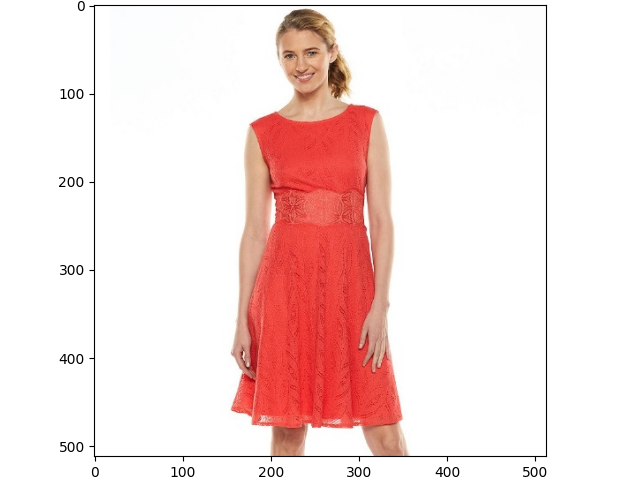

In [14]:
import torchOptics.optics as tt
import warnings 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision.transforms as trnasforms
import torch
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, random_split
import os
import glob
import math
warnings.filterwarnings('ignore') ## ignore warnings
warnings.filterwarnings('ignore') ## ignore warnings
# meta = {'wl' : (638e-9), 'dx':(6.3e-6, 6.3e-6)}
meta = {'wl' : (638e-9, 515e-9, 450e-9), 'dx':(6.3e-6, 6.3e-6)}
timg = tt.imread('512dataset/apparel/'+os.listdir('512dataset/apparel')[100], meta = meta)
# field = timg.clone()

tt.show(timg)

In [3]:
!nvidia-smi

Thu Mar 14 02:03:32 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:67:00.0 Off |                  N/A |
|  0%   23C    P2   108W / 350W |    659MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
!tasklist

/bin/bash: tasklist: command not found


In [29]:
target = timg.unsqueeze(0)
output = fcn(target)['out']

In [30]:
output.shape

torch.Size([1, 3, 512, 512])

In [19]:
pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
def get_psnr(img1, img2, min_value=0, max_value=1):
    """
    psnr 을 계산해준다.
    이미지가 [0., 255] 이면 min_value=0, max_valu=255 로 해주고,
    이미지가 [-1,1]의 범위에 있으면 min_value=-1, max_valu=1 로 설정 해준다.
    """
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = max_value - min_value
    return 10 * torch.log10((PIXEL_MAX ** 2) / mse)

In [5]:
class Dataset512(Dataset):
    # binary hologram and simulation dataset
    # x : simulation
    # y : binary hologram
    def __init__(self, target_dir, meta, transform = None):
        self.target_dir = target_dir
        # self.sim_dir = sim_dir
        self.transform = transform
        self.meta = meta
        self.target_list = sorted(glob.glob(target_dir+'*.jpeg'))
        # self.sim_list = sorted(glob.glob(sim_dir+'*.png'))
    def __len__(self):
        return len(self.target_list)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        target = tt.imread(self.target_list[idx], meta=meta)
        # target = target.unsqueeze(0)
        # sim = tt.imread(self.sim_list[idx],meta = meta, gray = True)
        # sample = {'target' : target}
        return target

In [6]:
batch_size = 8
target_dir = '512dataset/dishes/'
# sim_dir = 'binary_dataset/simulated/'
meta = {'wl' : (638e-9, 515e-9, 450e-9), 'dx':(6.3e-6, 6.3e-6)}
target_dataset = Dataset512(target_dir = target_dir, meta = meta)
size = len(target_dataset)
# dataloader = DataLoader(binary_dataset, batch_size = batch_size, shuffle = True)
train_size = int(size * 0.8)
valid_size = size - train_size

train_dataset, valid_dataset = random_split(target_dataset, [train_size, valid_size])
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validloader = DataLoader(valid_dataset, shuffle = True)

In [7]:
torch.save(fcn, 'models/test.pt')

In [8]:
import torch.nn
from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()
writer = SummaryWriter()
z = 5e-3
epochs = 5000
lr_val = 0.0001
optimizer = torch.optim.Adam(fcn.parameters(), lr = lr_val)
criterion = nn.MSELoss()
valid_image = valid_dataset[0].unsqueeze(0)
path = 'models/'
loss_prev = 1000
for epoch in range(epochs):
    for batch_idx, target in enumerate(trainloader):
        pred = fcn(target)['out']
        # pred = sign_function(pred)
        sim = tt.simulate(pred, z)
        # sim = torch.sum(sim, dim=1)/10
        loss = criterion(target, sim.abs()**2)
        # loss = criterion(target, pred)
        writer.add_scalar("Loss/train", loss, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
        print(f'Epoch {epoch:4d}/{epochs} Batch {batch_idx + 1}/{len(trainloader)} Cost: {loss.item():.6f}')
    pred = fcn(valid_image)['out']
    sim = tt.simulate(pred, z)
    # sim = torch.sum(sim, dim=1)/10
    sim = sim.abs()**2
    valid_loss = criterion(valid_image, sim)
    psnr = get_psnr(valid_image, sim)
    writer.add_scalar("PSNR/train", psnr, epoch)
    print(f'------ valid : Epoch {epoch:4d}/{epochs} MSE : {valid_loss.item():.6f} PSNR : {psnr}')
    if loss.item() < loss_prev:
        torch.save(fcn, path + 'fcn.pt')
writer.close()

Epoch    0/5000 Batch 1/119 Cost: 0.305461
Epoch    0/5000 Batch 2/119 Cost: 2506.522217
Epoch    0/5000 Batch 3/119 Cost: 1.782868
Epoch    0/5000 Batch 4/119 Cost: 0.260019
Epoch    0/5000 Batch 5/119 Cost: 0.641440
Epoch    0/5000 Batch 6/119 Cost: 1.508553
Epoch    0/5000 Batch 7/119 Cost: 1.241135
Epoch    0/5000 Batch 8/119 Cost: 0.805104
Epoch    0/5000 Batch 9/119 Cost: 0.464874
Epoch    0/5000 Batch 10/119 Cost: 0.405991
Epoch    0/5000 Batch 11/119 Cost: 0.318026
Epoch    0/5000 Batch 12/119 Cost: 0.267667
Epoch    0/5000 Batch 13/119 Cost: 0.293062
Epoch    0/5000 Batch 14/119 Cost: 0.271220
Epoch    0/5000 Batch 15/119 Cost: 0.215739
Epoch    0/5000 Batch 16/119 Cost: 0.171183
Epoch    0/5000 Batch 17/119 Cost: 0.179316
Epoch    0/5000 Batch 18/119 Cost: 0.110805
Epoch    0/5000 Batch 19/119 Cost: 0.133980
Epoch    0/5000 Batch 20/119 Cost: 0.147324
Epoch    0/5000 Batch 21/119 Cost: 0.165010
Epoch    0/5000 Batch 22/119 Cost: 0.166461
Epoch    0/5000 Batch 23/119 Cost: 0.1

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



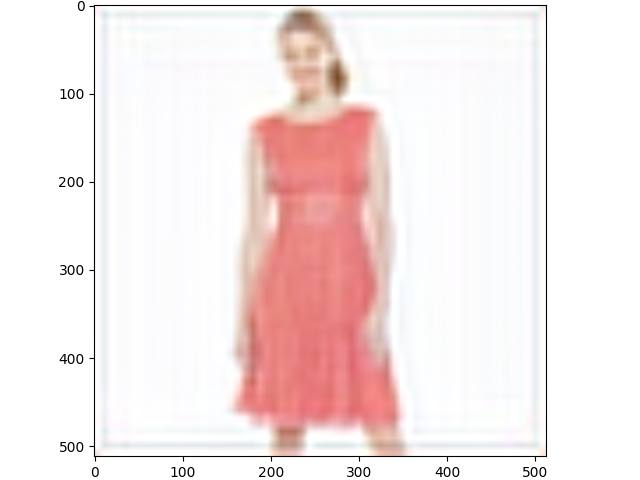

In [15]:
output = fcn(timg.unsqueeze(0))['out']
tt.show(output)
# out.dtype

In [16]:
timg.shape

torch.Size([3, 512, 512])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



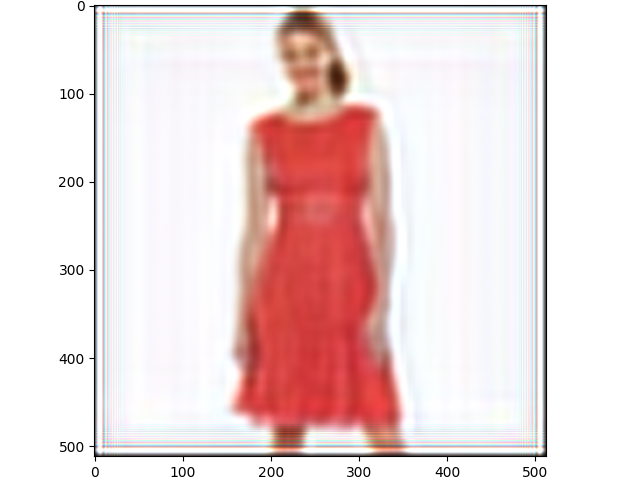

In [17]:
sim = tt.simulate(output, 5e-3).abs()**2
tt.show(sim)
# get_psnr(sim.abs()**2, target)

In [18]:
get_psnr(sim, timg)

18.251087188720703